In [1]:
import numpy as np
from skimage import io
from skimage import exposure
from skimage import color

import supervisely_lib as sly

import os

from matplotlib import pyplot as plt


import mpld3
mpld3.enable_notebook()

import particle_extraction as pe
import porespy as ps

In [2]:
# Change this field to the name of your team, where target workspace exists.
team_name = "marcwang17" # Automatically inserted

# Change this field to the of your workspace, where target project exists.
workspace_name = "First Workspace" # Automatically inserted

# If you are running this notebook on a Supervisely web instance, the connection
# Edit those values if you run this notebook on your own PC
# details below will be filled in from environment variables automatically.
#
# If you are running this notebook locally on your own machine, edit to fill in the
# connection details manually. You can find your access token at
# "Your name on the top right" -> "Account settings" -> "API token".
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [3]:
# Initialize API object
api = sly.Api(address, token)

In [4]:
project_name = 'full_img_inference'

In [5]:
# Get IDs of team and workspace
team = api.team.get_info_by_name(team_name)
workspace = api.workspace.get_info_by_name(team.id, workspace_name)

In [6]:
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("project {!r} not found".format(project_name))

In [7]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print(meta)

ProjectMeta:
Object Classes
+---------------+-----------+----------------+
|      Name     |   Shape   |     Color      |
+---------------+-----------+----------------+
|    particle   |   Bitmap  | [177, 36, 25]  |
|       bg      | Rectangle | [15, 130, 138] |
| particle_unet |   Bitmap  | [177, 36, 25]  |
|    bg_unet    |   Bitmap  | [15, 120, 138] |
+---------------+-----------+----------------+
Tags
+------+------------+-----------------+
| Name | Value type | Possible values |
+------+------------+-----------------+
+------+------------+-----------------+



In [8]:
datasets = api.dataset.get_list(project.id)

In [9]:
images = api.image.get_list(datasets[0].id)

Image Shape: (600, 600, 3)


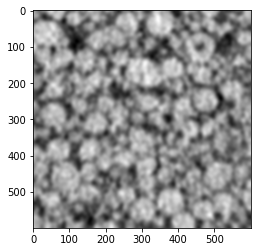

In [10]:
# Download and display the image.
image = images[0]
img = api.image.download_np(image.id)
print("Image Shape: {}".format(img.shape))
imgplot = plt.imshow(img)

In [11]:
# Download the serialized JSON annotation for the image.
ann_info = api.annotation.download(image.id)
# Parse the annotation using the Supervisely Python SDK
# and instantiate convenience wrappers for the objects in the annotation.
ann = sly.Annotation.from_json(ann_info.annotation, meta)

In [12]:
from skimage import color
from skimage import filters

gray_img = color.rgb2gray(img)

otsu_thres = filters.threshold_otsu(gray_img)
bin_img = gray_img > otsu_thres

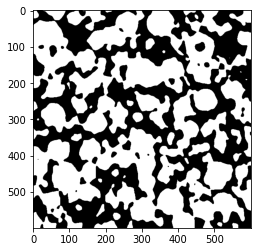

In [13]:
plt.imshow(bin_img, cmap= 'gray')
plt.show()

In [14]:
def get_annotation(name):
    def func(label):
        obj_name = label.obj_class.name
        
        if(obj_name == name):
            return True
        else:
            return False
    return func

filter_func = get_annotation('particle_unet')

ann_filtered = filter(filter_func,ann.labels)

In [15]:
ls_im = []
for p_unet in ann_filtered:
    ls_im.append(p_unet.geometry)

In [16]:
mask = np.ones(img.shape[:2])

new_bitmap = None

for geo in ls_im:
    new_bitmap = geo.bitwise_mask(mask, np.logical_and)

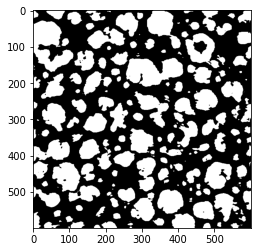

In [17]:
plt.imshow(new_bitmap.data, cmap = 'gray')
plt.show()

In [18]:
bin_img.shape

(600, 600)

In [27]:
unet_reg, unet_net = pe.watershed_seg(new_bitmap.data, size=np.ones((5, 5)), sigma=0.4, peak_threshold = 0.2)

unet_reg_disp = ps.tools.randomize_colors(unet_reg)

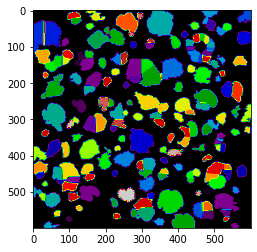

In [28]:
plt.imshow(unet_reg_disp, cmap=plt.cm.nipy_spectral)
plt.show()

In [36]:
m_reg, m_net = pe.merge_net(unet_net, unet_reg, 0.9)

In [37]:
m_reg_disp = ps.tools.randomize_colors(m_reg)

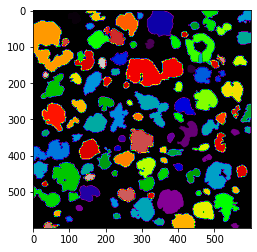

In [38]:
plt.imshow(m_reg_disp, cmap=plt.cm.nipy_spectral)
plt.show()